In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

from algorithm import *
from entity import CW_Func_Handler, CW_Source, Three_Elements_Array, Array_Data_Sampler
from utils import *

## 仿真实验


### 声场仿真

几何模型:
- 以三元阵中心为原点, 其中阵元1在x轴负半轴
- 声源S角度为角度制下极坐标角度

运动模型:
- 声源S静止
- 三元阵以相对于三元阵初始坐标轴的速度运动

In [15]:
c = 1500
fc = 42000  # 声源频率
sample_interval = 1  # 采样时长
fs = 8 * fc  # 倍频采样频率
# fs = 500000  # 500k采样率

d = 0.5
K = 1

vel_angle = 90
speed = 1
r = 1000
angle = 50

velocity = deg_pol2cart(speed, vel_angle)

target_sig = CW_Func_Handler(
    f=fc,  # 声源频率
    prf=1,  # Cw信号周期
    pulse_width=10e-3,  # Cw信号脉宽
)
array_data_sampler = Array_Data_Sampler(
    CW_Source(
    signal_func_callback=target_sig,
    r=r,  # 声源距离
    angle=angle,  # 声源角度
    # seed=1,
),
    Three_Elements_Array(
        d=d,
        K=K,
        # seed=1000
    ),
    c=c  # 声速
)

# snapshot_generator.source.set_noise_params(1e2)
array_data_sampler.set_SNR(30)
# snapshot_generator.set_SNR(20)
# snapshot_generator.set_SNR(10)
# snapshot_generator.set_SNR(0)
# snapshot_generator.set_SNR(-5)
# snapshot_generator.set_SNR(-10)
# snapshot_generator.set_SNR(-15)
# snapshot_generator.set_SNR(-20)

# snapshot_generator.set_ideal()

#### 生成各阵元电信号AD采样后信号

In [23]:
t = np.arange(0, sample_interval, 1 / fs)
x, r_real, angle_real = array_data_sampler(t, velocity)

64.5 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


##### 信号图像

In [17]:
# tf_plot(x[0], fs)
# rfft_plot(x[0], fs, fc=37.5e3, bandwidth=2e3)

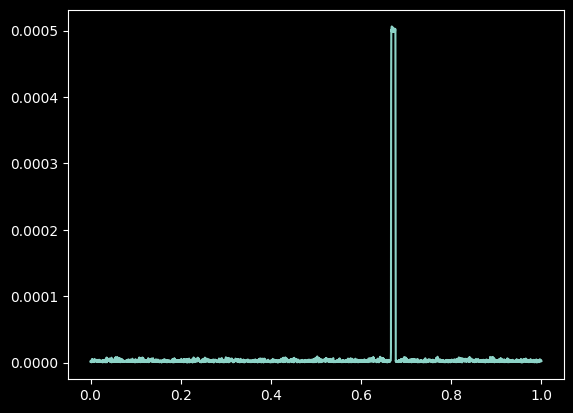

In [18]:
f, t1, Zxx = signal.stft(x[0], fs)
plt.plot(t1, np.abs(Zxx[np.argmin(np.abs(f-target_sig.f)),:]))
plt.show()

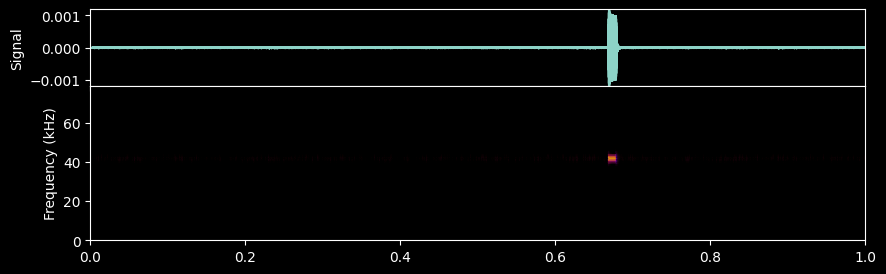

In [19]:
sos = signal.butter(20, (target_sig.f - 1000, target_sig.f + 1000), 'bandpass', fs=fs, output='sos')
pow_num = 1
x_filtered = [signal.sosfilt(sos, x_i)**pow_num for x_i in x]
# rfft_plot(x_filtered[0], fs, fc=37.5e3)
tf_plot(x_filtered[0], fs)

### 定位

#### 时延估计

In [20]:
x = x_filtered
tau12_hat = time_delay_estimation(x[0], x[1], target_sig.f, fs, 'xcorr')
tau23_hat = time_delay_estimation(x[1], x[2], target_sig.f, fs, 'xcorr')

#### 解算方位

In [21]:
r_far, angle_far = far_locate(tau12_hat, tau23_hat, array_data_sampler.c, array_data_sampler.array.K, array_data_sampler.array.d)
# r_near, angle_near = near_locate(tau12_hat, tau23_hat, snapshot_generator.c, snapshot_generator.array.K, snapshot_generator.array.d)
analysis(array_data_sampler, tau12_hat, tau23_hat, r_far, angle_far, vel_angle)

/home/leo/Desktop/ternary-array-passive-bearing/algorithm.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  K * (K + 1) * ((d * np.sin(theta)) ** 2)


,angle,tau12,tau23,r
real,50.000000,2.143114e-04,2.142136e-04,1000.0
estimation,49.994799,2.142857e-04,2.142857e-04,inf
abs_error,-0.005201,-2.570857e-08,7.209545e-08,inf
rel_error,0.000130,-1.199589e-04,3.365587e-04,inf
